# Belief Propagation

Reference: https://qiita.com/clientver2/items/06b87aca1ac72bae3ea1

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.transform import resize
from tqdm import tqdm

In [2]:
!wget "https://www.pakutaso.com/shared/img/thumb/tomcat1582_TP_V.jpg"

--2022-01-06 00:33:20--  https://www.pakutaso.com/shared/img/thumb/tomcat1582_TP_V.jpg
Resolving www.pakutaso.com (www.pakutaso.com)... 180.235.251.31
Connecting to www.pakutaso.com (www.pakutaso.com)|180.235.251.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346458 (338K) [image/jpeg]
Saving to: ‘tomcat1582_TP_V.jpg.3’

tomcat1582_TP_V.jpg 100%[===================>] 338.34K  1.82MB/s    in 0.2s    

2022-01-06 00:33:20 (1.82 MB/s) - ‘tomcat1582_TP_V.jpg.3’ saved [346458/346458]



In [3]:
def add_noise(binary_image):
    flags  = np.random.binomial(n=1, p=0.05, size=binary_image.shape)
    noise = flags * (1 - 2 * binary_image)
    return binary_image + noise

In [4]:
raw_image = cv2.imread("tomcat1582_TP_V.jpg", 0)

resize_factor = 0.2
output_shape = tuple(s * resize_factor for s in raw_image.shape)
raw_image = resize(raw_image, output_shape)

binary_image = (raw_image > threshold_otsu(raw_image)).astype(np.int8)
noise_image = add_noise(binary_image)

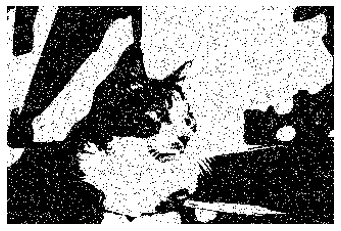

In [5]:
plt.gray()
plt.imshow(noise_image)
plt.axis('off')
plt.show()

In [18]:
class Node:
    _alpha = 10.0
    _beta = 5.0

    def __init__(self, id):
        self.id = id
        self.neighbor = []
        self.message = {}
        self.prob = None

    def add_neighbor(self, node):
        self.neighbor.append(node)

    def init_message(self):
        for neighbor in self.neighbor:
            self.message[neighbor] = np.ones(2)

    def marginalize(self):
        prob = np.ones(2)
        for message in self.message.values():
            prob *= message

        self.prob = prob / np.sum(prob)

    def send_message(self, target):
        neighbor_message = 1.0
        for neighbor, message in self.message.items():
            if neighbor != target:
                neighbor_message *= message

        compatibility_0 = np.array([1, np.exp(-self._beta)])
        compatibility_1 = np.array([np.exp(-self._beta), 1])

        message = np.array([np.sum(neighbor_message * compatibility_0),
                            np.sum(neighbor_message * compatibility_1)])
        return message / np.sum(message)

    def calc_likelihood(self, value):
        if value == 0:
            likelihood = [1, np.exp(-self._alpha)]
        else:
            likelihood = [np.exp(-self._alpha), 1]
        self.message[self] = np.array(likelihood)

class MRF:
    def __init__(self):
        self.nodes = []
        self.node_ids = {}

    def add_node(self, node_id, node):
        self.nodes.append(node)
        self.node_ids[node_id] = node

    def get_node(self, node_id):
        return self.node_ids[node_id]

    def belief_propagation(self, num_iters=20):
        for node in self.nodes:
            node.init_message()

        for t in tqdm(np.arange(num_iters)):
            for node in self.nodes:
                for neighbor in node.neighbor:
                    neighbor.message[node] = node.send_message(neighbor)

        for node in self.nodes:
            node.marginalize()

In [19]:
def generate_belief_net(image):
    height, width = image.shape

    network = MRF()
    for node_id in range(height * width):
        network.add_node(node_id, Node(node_id))

    dy = [-1, 0, 0, 1]
    dx = [0, -1, 1, 0]

    for h in range(height):
        for w in range(width):
            node = network.get_node(width * h + w)

            for k in range(4):
                h_dy, w_dx = h + dy[k], w + dx[k]
                if h_dy >= 0 and h_dy < height and w_dx >= 0 and w_dx < width:
                    neighbor = network.get_node(width * h_dy + w_dx)
                    node.add_neighbor(neighbor)

    return network

In [20]:
network = generate_belief_net(noise_image)

In [21]:
height, width = noise_image.shape

for h in range(height):
    for w in range(width):
        node = network.get_node(width * h + w)
        node.calc_likelihood(noise_image[h, w])

In [22]:
network.belief_propagation()

100%|██████████████████████████████████████████████████████| 20/20 [03:11<00:00,  9.58s/it]


In [23]:
output = np.zeros(noise_image.shape)

for h in range(height):
    for w in range(width):
        node = network.get_node(width * h + w)
        p0, p1 = node.prob
        if p1 > p0:
            output[h, w] = 1

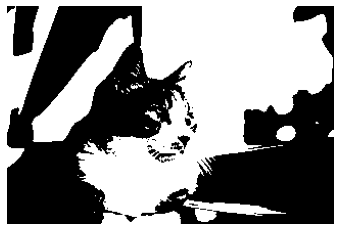

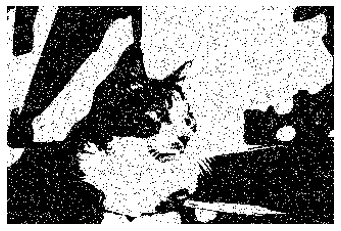

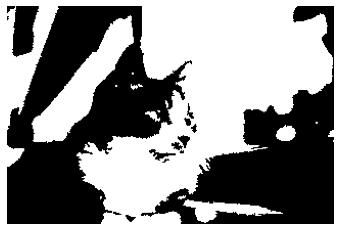

In [29]:
plt.imshow(binary_image)
plt.axis('off')
plt.show()

plt.imshow(noise_image)
plt.axis('off')
plt.show()

plt.imshow(output)
plt.axis('off')
plt.show()